## Подготовка данных

In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from skimage.io import imread
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def fetch_dataset(
    attrs_name="lfw_attributes.txt",
    images_name="lfw-deepfunneled",
    dx=80,
    dy=80,
    dimx=64,
    dimy=64,
):

    # download if not exists
    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system(
            "wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz"
        )
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(
            "wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"
            % attrs_name
        )
        print("done")

    # read attrs
    df_attrs = pd.read_csv(
        "lfw_attributes.txt",
        sep="\t",
        skiprows=1,
    )
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace("_", " ").split()
                person_id = " ".join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append(
                    {"person": person_id, "imagenum": photo_number, "photo_path": fpath}
                )

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs, photo_ids, on=("person", "imagenum"))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    all_photos = (
        df["photo_path"]
        .apply(imread)
        .apply(lambda img: img[dy:-dy, dx:-dx])
        .apply(lambda img: resize(img, [dimx, dimy]))
    )

    all_photos = np.stack(all_photos.values)  # .astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [4]:
data, attrs = fetch_dataset()
print("Total amount of images: ", data.shape[0])

data_train, data_val, attrs_train, attrs_val = train_test_split(
    data, attrs, test_size=0.25
)
print("Train shape: ", data_train.shape, " Val shape: ", data_val.shape)

Total amount of images:  13143
Train shape:  (9857, 64, 64, 3)  Val shape:  (3286, 64, 64, 3)


Посмотрим на некоторые картинки из датасета:

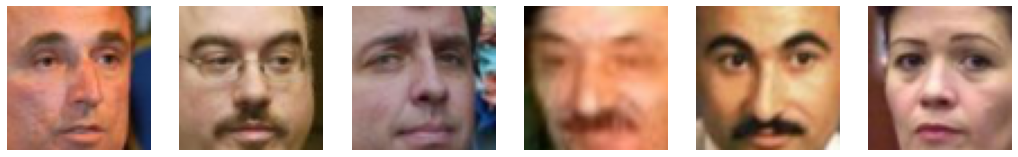

In [5]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(data_train[i])
plt.show()

## AutoEncoder


Определим несколько полезных функций, а также структуру самой модели:

In [6]:
class ImgDataset(data_utils.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.img_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                # ),
            ]
        )

    def __getitem__(self, index):
        image = data[index]
        image = self.img_transforms(image).to(torch.float32)
        return image

    def __len__(self):
        return self.data.shape[0]

In [7]:
class Make_flat(nn.Module):
    def __init__(self):
        super(Make_flat, self).__init__()
        self.make_flat = torch.Tensor.reshape

    def forward(self, x):
        x = self.make_flat(x, x.size(0), -1)
        return x


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.reshape = Make_flat()
        self.linear_layers = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Linear(2048, latent_dim),
        )

    def forward(self, x):
        x = self.features_extractor(x)  # (batch, 64, 8, 8)
        x = self.reshape(x)  # (batch, 4096)
        x = self.linear_layers(x)
        return x


class Restore_shape(nn.Module):
    def __init__(self):
        super(Restore_shape, self).__init__()
        self.restore_shape = torch.Tensor.view

    def forward(self, x):
        x = self.restore_shape(x, -1, 64, 8, 8)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 4096),
            nn.ReLU(True),
        )
        self.view = Restore_shape()
        self.transp_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.linear_layers(x)
        x = self.view(x)
        x = self.transp_conv(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        latent_code = x
        x = self.decoder(x)
        return x, latent_code

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    for epoch in range(num_epochs):
        print(
            "Epoch {}/{} (lr={:.2E})".format(
                epoch, num_epochs - 1, optimizer.param_groups[0]["lr"]
            )
        )
        print("-" * 25)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs in dataloaders[phase]:
                inputs = inputs.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs[0], inputs)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

        scheduler.step()
        history.append((train_loss, val_loss))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Loss: {:4f}".format(best_loss))

    model.load_state_dict(best_model_wts)
    return model, history


def process_batch(model, X_batch):
    with torch.no_grad():
        inputs = X_batch.to(device)
        model.eval()
        outputs = model(inputs)

    return outputs

Создадим загрузчики данных, сделаем экземпляр нашей модели, выберем оптимизатор... в общем подготовим все необходимое для обучения.

In [9]:
latent_dim = 512
batch_size = 256

train_dataset = ImgDataset(data_train)
train_loader = data_utils.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataset = ImgDataset(data_val)
val_loader = data_utils.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)

dataloaders_dict = {"train": train_loader, "val": val_loader}


In [10]:
model = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)

Конечная структура модели такова:

In [11]:
list(model.children())

[Encoder(
   (features_extractor): Sequential(
     (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): ReLU(inplace=True)
   )
   (reshape): Make_flat()
   (linear_layers): Sequential(
     (0): Linear(in_features=4096, out_features=2048, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=2048, out_features=512, bias=True)
   )
 ), Decoder(
   (linear_layers): Sequential(
     (0): Linear(in_features=512, out_features=2048, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=2048, out_features=4096, bias=True)
     (3): ReLU(inplace=True)
   )
   (view): Restore_shape()
   (transp_conv): Sequential(
     (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU(inplace=True)
     

Запустим обучение:

In [12]:
model, hist = train_model(
    model, dataloaders_dict, criterion, optimizer, scheduler, num_epochs=100
)

Epoch 0/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0398
val Loss: 0.0337

Epoch 1/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0298
val Loss: 0.0279

Epoch 2/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0250
val Loss: 0.0214

Epoch 3/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0197
val Loss: 0.0182

Epoch 4/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0164
val Loss: 0.0150

Epoch 5/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0137
val Loss: 0.0127

Epoch 6/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0123
val Loss: 0.0120

Epoch 7/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0119
val Loss: 0.0118

Epoch 8/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0118
val Loss: 0.0113

Epoch 9/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0108
val Loss: 0.0103

Epoch 10/99 (lr=1.00E-03)
-------------------------
train Loss: 0.0103
val Loss: 0.0098

Epoch 11/99 (lr=1.00E-03)
-----

Графически отобразим процесс обучения:

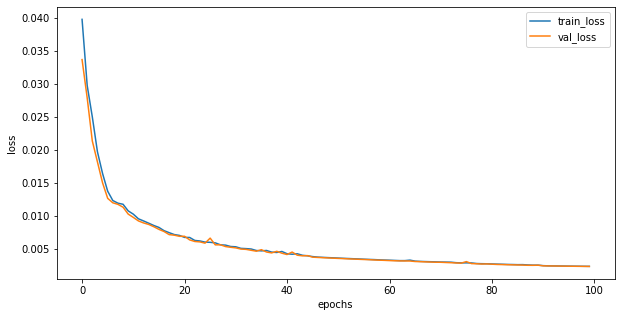

In [13]:
loss, val_loss = zip(*hist)

plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Посмотрим на исходные картинки и их восстановленные моделью версии:

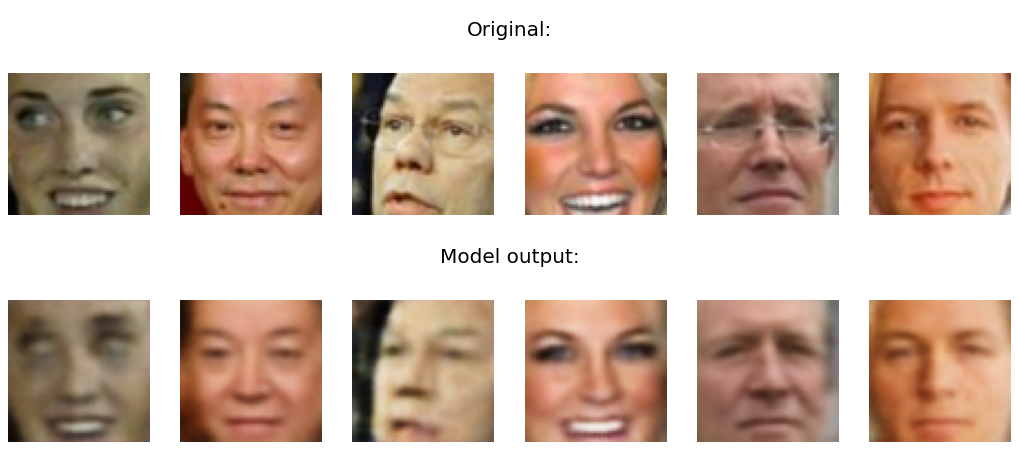

In [14]:
output_to_img = transforms.Compose(
    [
        # transforms.Normalize(
        #     mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.255],
        #     std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        # ),
        transforms.ToPILImage(),
    ]
)

batch = next(iter(val_loader))
output = process_batch(model, batch)

fig = plt.figure(figsize=(18, 8))
spec = fig.add_gridspec(ncols=6, nrows=4, height_ratios=[1, 3, 1, 3])

orig_ax = fig.add_subplot(spec[0, :])
orig_ax.text(0.5, 0.5, "Original:", ha="center", va="center", size=20)
orig_ax.axis("off")

for indx in range(6):
    f1_ax = fig.add_subplot(spec[1, indx])
    f1_ax.axis("off")
    f1_ax.imshow(output_to_img(batch[indx]))

    f2_ax = fig.add_subplot(spec[3, indx])
    f2_ax.axis("off")
    f2_ax.imshow(output_to_img(output[0][indx]))

sml_ax = fig.add_subplot(spec[2, :])
sml_ax.text(0.5, 0.5, "Model output:", ha="center", va="center", size=20)
sml_ax.axis("off")

plt.show()

А вот на что похожа функция плотности вероятности латентного слоя:

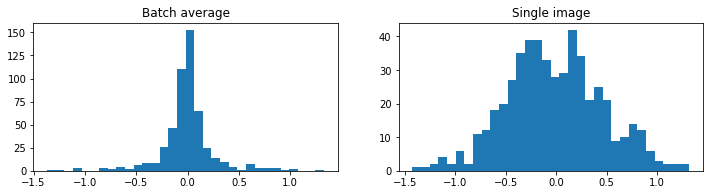

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Batch average")
plt.hist(output[1].mean(0).cpu().numpy(), bins=32)

plt.subplot(2, 2, 2)
plt.title("Single image")
plt.hist(output[1][0].cpu().numpy(), bins=32)
plt.show()

Попробуем сгенерировать лица несуществующих людей, подав в декодер выборку из нормального распределения (с мат. ожиданием и отклонением как у batch average):

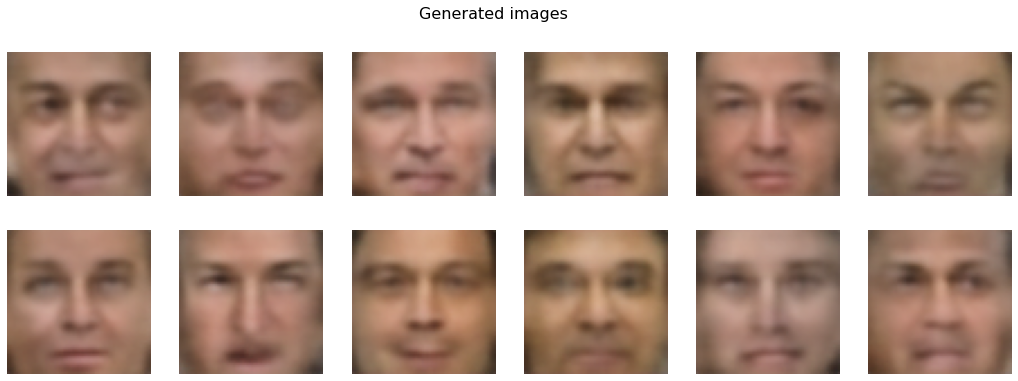

In [16]:
std, mean = torch.std_mean(output[1], dim=0)
batch_randn = std * torch.randn(batch_size, latent_dim).to(device) + mean
with torch.no_grad():
    model.eval()
    output_randn = model.decoder(batch_randn)
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Generated images", fontsize=16)
for indx in range(6):
    plt.subplot(2, 6, indx + 1)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx]))

    plt.subplot(2, 6, indx + 7)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx + 6]))

Во всем массиве данных найдем улыбающихся и грустных людей, получим их латентные представления:

In [17]:
print(
    "smiling min = ",
    attrs_train["Smiling"].min(),
    "; max = ",
    attrs_train["Smiling"].max(),
)

happy_indx = sorted(list(attrs[attrs["Smiling"] >= 2.6]["Smiling"].index))
sad_indx = sorted(list(attrs[attrs["Smiling"] <= -2.45]["Smiling"].index))

batch_happy = []
for indx, elem in enumerate(data[happy_indx]):
    img = transforms.ToTensor()(elem).to(torch.float32)
    batch_happy.append(img)
batch_happy = torch.stack(batch_happy)

batch_sad = []
for indx, elem in enumerate(data[sad_indx]):
    img = transforms.ToTensor()(elem).to(torch.float32)
    batch_sad.append(img)
batch_sad = torch.stack(batch_sad)

print("total amount of happy =", batch_happy.size(0), " / sad =", batch_sad.size(0))

with torch.no_grad():
    model.eval()
    happy_lat_dim = model.encoder(batch_happy.to(device)).mean(0)
    sad_lat_dim = model.encoder(batch_sad.to(device)).mean(0)

smiling min =  -2.68659390331 ; max =  2.83999377045
total amount of happy = 17  / sad = 20


Дорисуем улыбки на нескольких изображениях:

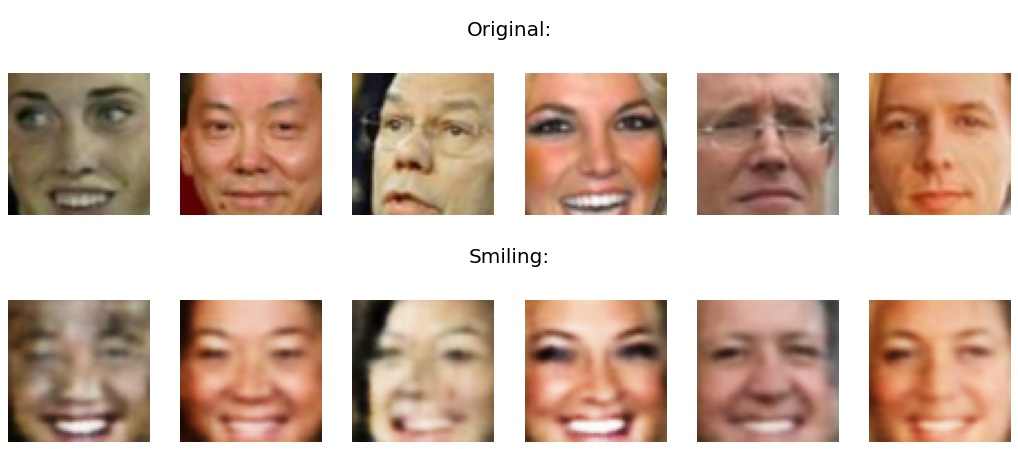

In [18]:
happy_lat_dim = happy_lat_dim.unsqueeze(0).repeat(batch_size, 1)
sad_lat_dim = sad_lat_dim.unsqueeze(0).repeat(batch_size, 1)

with torch.no_grad():
    model.eval()
    lat_dim = model.encoder(batch.to(device))
    lat_dim = lat_dim + happy_lat_dim - sad_lat_dim
    outputs = model.decoder(lat_dim)


fig = plt.figure(figsize=(18, 8))
spec = fig.add_gridspec(ncols=6, nrows=4, height_ratios=[1, 3, 1, 3])

orig_ax = fig.add_subplot(spec[0, :])
orig_ax.text(0.5, 0.5, "Original:", ha="center", va="center", size=20)
orig_ax.axis("off")

for indx in range(6):
    f1_ax = fig.add_subplot(spec[1, indx])
    f1_ax.axis("off")
    f1_ax.imshow(output_to_img(batch[indx]))

    f2_ax = fig.add_subplot(spec[3, indx])
    f2_ax.axis("off")
    f2_ax.imshow(output_to_img(outputs[indx]))

sml_ax = fig.add_subplot(spec[2, :])
sml_ax.text(0.5, 0.5, "Smiling:", ha="center", va="center", size=20)
sml_ax.axis("off")

plt.show()

## Variational AutoEncoder


Повторим все шаги из прошлого пункта:

In [19]:
class GetMeanLogvar(nn.Module):
    def __init__(self, latent_dim):
        super(GetMeanLogvar, self).__init__()
        self.mean = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar


class Reparameterize(nn.Module):
    def __init__(self):
        super(Reparameterize, self).__init__()

    def forward(self, mean, logvar):
        norm_sample = torch.randn_like(mean)
        std = torch.exp(0.5 * logvar)  # variance = std^2
        sample = std * norm_sample + mean
        return sample


class Make_flat(nn.Module):
    def __init__(self):
        super(Make_flat, self).__init__()
        self.make_flat = torch.Tensor.reshape

    def forward(self, x):
        x = self.make_flat(x, x.size(0), -1)
        return x


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.reshape = Make_flat()
        self.linear_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(True),
        )
        self.get_mean_logvar = GetMeanLogvar(latent_dim)
        self.reparameterize = Reparameterize()

    def forward(self, x):
        x = self.features_extractor(x)  # (batch, 32, 8, 8)
        x = self.reshape(x)  # (batch, 2048)
        x = self.linear_layers(x)
        mean, logvar = self.get_mean_logvar(x)
        x = self.reparameterize(mean, logvar)
        return x, mean, logvar


class Restore_shape(nn.Module):
    def __init__(self):
        super(Restore_shape, self).__init__()
        self.restore_shape = torch.Tensor.view

    def forward(self, x):
        x = self.restore_shape(x, -1, 32, 8, 8)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
        )
        self.view = Restore_shape()
        self.transp_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.linear_layers(x)
        x = self.view(x)
        x = self.transp_conv(x)
        return x


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        x, mean, logvar = self.encoder(x)
        x = self.decoder(x)
        return x, mean, logvar


bce_loss = nn.BCELoss(reduction="sum")


def loss_vae(reconstruction, mean, logvar, original):
    bce = bce_loss(reconstruction, original)
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - torch.exp(logvar))
    return bce + kld

In [20]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    for epoch in range(num_epochs):
        print(
            "Epoch {}/{} (lr={:.2E})".format(
                epoch, num_epochs - 1, optimizer.param_groups[0]["lr"]
            )
        )
        print("-" * 25)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs in dataloaders[phase]:
                inputs = inputs[0].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(*outputs, inputs)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

        scheduler.step()
        history.append((train_loss, val_loss))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Loss: {:4f}".format(best_loss))

    model.load_state_dict(best_model_wts)
    return model, history

In [21]:
batch_size = 512

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

train_dataset = datasets.MNIST(
    root="../mnist", train=True, download=True, transform=transform
)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.MNIST(
    root="../mnist", train=False, download=True, transform=transform
)
val_loader = data_utils.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_loader, "val": val_loader}

In [22]:
model = VAE(latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)

Окончательная структура VAE следующая:

In [23]:
list(model.children())

[Encoder(
   (features_extractor): Sequential(
     (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (3): ReLU(inplace=True)
   )
   (reshape): Make_flat()
   (linear_layers): Sequential(
     (0): Linear(in_features=2048, out_features=1024, bias=True)
     (1): ReLU(inplace=True)
   )
   (get_mean_logvar): GetMeanLogvar(
     (mean): Linear(in_features=1024, out_features=512, bias=True)
     (logvar): Linear(in_features=1024, out_features=512, bias=True)
   )
   (reparameterize): Reparameterize()
 ), Decoder(
   (linear_layers): Sequential(
     (0): Linear(in_features=512, out_features=1024, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=1024, out_features=2048, bias=True)
     (3): ReLU(inplace=True)
   )
   (view): Restore_shape()
   (transp_conv): Sequential(
     (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), pad

Запустим обучение:

In [24]:
model, hist = train_model(
    model, dataloaders_dict, loss_vae, optimizer, scheduler, num_epochs=100
)

Epoch 0/99 (lr=1.00E-03)
-------------------------
train Loss: 157292.5664
val Loss: 128828.6355

Epoch 1/99 (lr=1.00E-03)
-------------------------
train Loss: 129223.4496
val Loss: 122078.0238

Epoch 2/99 (lr=1.00E-03)
-------------------------
train Loss: 115873.5819
val Loss: 107360.4920

Epoch 3/99 (lr=1.00E-03)
-------------------------
train Loss: 105439.8507
val Loss: 99447.5969

Epoch 4/99 (lr=1.00E-03)
-------------------------
train Loss: 97519.8051
val Loss: 92301.1361

Epoch 5/99 (lr=1.00E-03)
-------------------------
train Loss: 91229.9669
val Loss: 87401.1205

Epoch 6/99 (lr=1.00E-03)
-------------------------
train Loss: 87528.3555
val Loss: 84745.8143

Epoch 7/99 (lr=1.00E-03)
-------------------------
train Loss: 84676.7300
val Loss: 81692.0707

Epoch 8/99 (lr=1.00E-03)
-------------------------
train Loss: 82388.1780
val Loss: 80102.1445

Epoch 9/99 (lr=1.00E-03)
-------------------------
train Loss: 80805.5584
val Loss: 78775.8414

Epoch 10/99 (lr=1.00E-03)
-------

Посмотрим на статистику обучения и результаты работы модели:

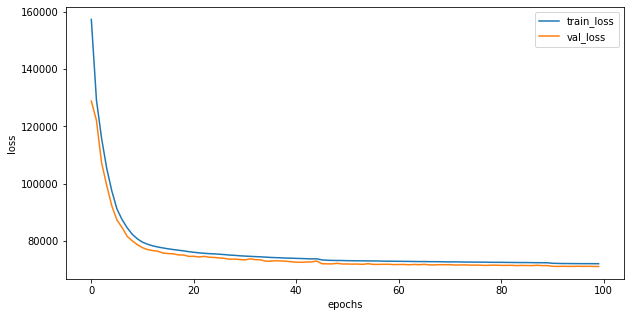

In [25]:
loss, val_loss = zip(*hist)

plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

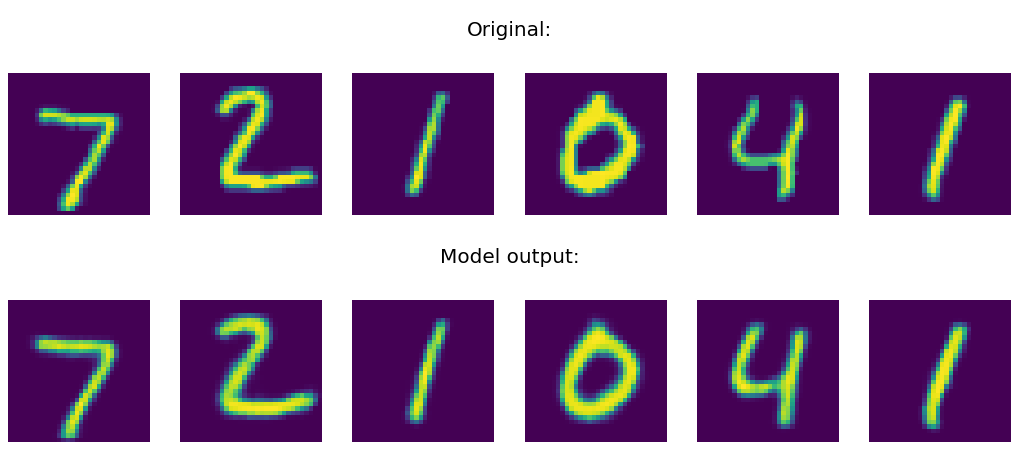

In [26]:
batch = next(iter(val_loader))[0]
output = process_batch(model, batch)

fig = plt.figure(figsize=(18, 8))
spec = fig.add_gridspec(ncols=6, nrows=4, height_ratios=[1, 3, 1, 3])

orig_ax = fig.add_subplot(spec[0, :])
orig_ax.text(0.5, 0.5, "Original:", ha="center", va="center", size=20)
orig_ax.axis("off")

for indx in range(6):
    f1_ax = fig.add_subplot(spec[1, indx])
    f1_ax.axis("off")
    f1_ax.imshow(output_to_img(batch[indx]))

    f2_ax = fig.add_subplot(spec[3, indx])
    f2_ax.axis("off")
    f2_ax.imshow(output_to_img(output[0][indx]))

sml_ax = fig.add_subplot(spec[2, :])
sml_ax.text(0.5, 0.5, "Model output:", ha="center", va="center", size=20)
sml_ax.axis("off")

plt.show()

Сгенерируем несколько "цифр" по заданному нормальному распределению:

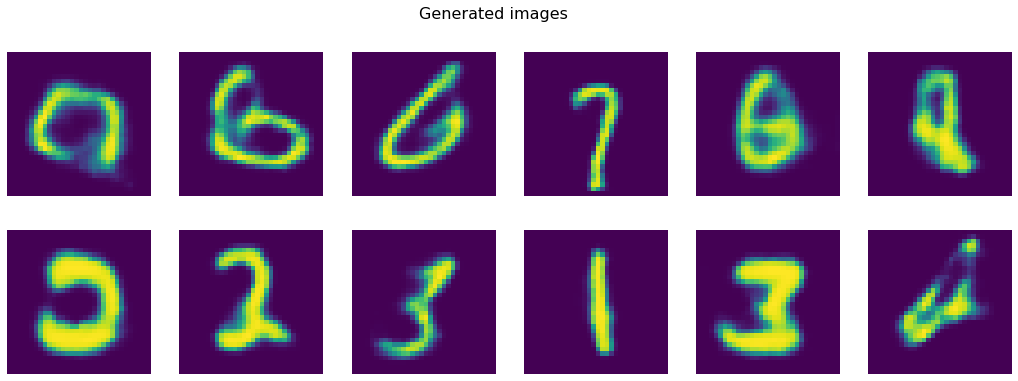

In [27]:
with torch.no_grad():
    output_randn = model.decoder(torch.randn(20, latent_dim).to(device))
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Generated images", fontsize=16)
for indx in range(6):
    plt.subplot(2, 6, indx + 1)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx]))

    plt.subplot(2, 6, indx + 7)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx + 6]))

Для всего датасета визуализируем латентое пространство таким образом, что похожие объекты будут расположены рядом друг с другом:

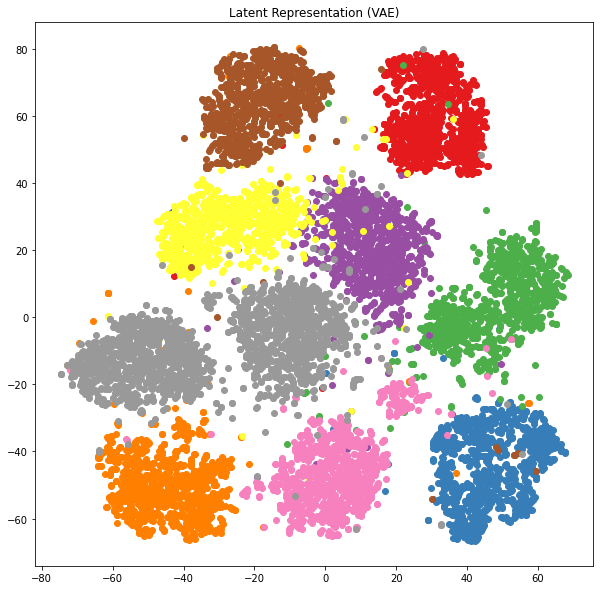

In [28]:
total_mean = []
with torch.no_grad():
    for data in val_loader:
        _, mean, _ = model.encoder(data[0].to(device))
        total_mean.append(mean)

total_mean = torch.cat(total_mean, 0).cpu().numpy()
model_tsne = TSNE(n_components=2, random_state=42)
total_mean = model_tsne.fit_transform(total_mean)
classes = val_loader.dataset.targets.cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for ind in range(10):
    indxs = np.where(classes == ind)
    color = plt.cm.Set1(ind)
    plt.scatter(total_mean[indxs][:, 0], total_mean[indxs][:, 1], color=color)
plt.title("Latent Representation (VAE)")
plt.show()

Понятно что группы точек представляют собой цифры.

## Conditional Variational AutoEncoder


In [29]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.reshape = Make_flat()
        self.linear_layers = nn.Sequential(
            nn.Linear(2048 + 10, 1024),
            nn.ReLU(True),
        )
        self.get_mean_logvar = GetMeanLogvar(latent_dim)
        self.reparameterize = Reparameterize()

    def forward(self, x, onehot_classes):
        x = self.features_extractor(x)
        x = self.reshape(x)
        x = torch.cat((onehot_classes, x), 1)
        x = self.linear_layers(x)
        mean, logvar = self.get_mean_logvar(x)
        x = self.reparameterize(mean, logvar)
        return x, mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(latent_dim + 10, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
        )
        self.view = Restore_shape()
        self.transp_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, onehot_classes):
        x = torch.cat((onehot_classes, x), 1)
        x = self.linear_layers(x)
        x = self.view(x)
        x = self.transp_conv(x)
        return x


class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x, onehot_classes):
        x, mean, logvar = self.encoder(x, onehot_classes)
        x = self.decoder(x, onehot_classes)
        return x, mean, logvar

In [30]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    for epoch in range(num_epochs):
        print(
            "Epoch {}/{} (lr={:.2E})".format(
                epoch, num_epochs - 1, optimizer.param_groups[0]["lr"]
            )
        )
        print("-" * 25)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs in dataloaders[phase]:
                onehot_classes = torch.zeros(inputs[1].size(0), 10).to(device)
                for ind, elem in enumerate(onehot_classes):
                    elem[inputs[1][ind]] = 1
                inputs = inputs[0].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs, onehot_classes)
                    loss = criterion(*outputs, inputs)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss = epoch_loss
            else:
                val_loss = epoch_loss

        scheduler.step()
        history.append((train_loss, val_loss))
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Loss: {:4f}".format(best_loss))

    model.load_state_dict(best_model_wts)
    return model, history

In [31]:
model = CVAE(latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)

In [32]:
model, hist = train_model(
    model, dataloaders_dict, loss_vae, optimizer, scheduler, num_epochs=100
)

Epoch 0/99 (lr=1.00E-03)
-------------------------
train Loss: 158697.7159
val Loss: 128328.5941

Epoch 1/99 (lr=1.00E-03)
-------------------------
train Loss: 123761.0458
val Loss: 110155.5443

Epoch 2/99 (lr=1.00E-03)
-------------------------
train Loss: 105288.6279
val Loss: 98705.8074

Epoch 3/99 (lr=1.00E-03)
-------------------------
train Loss: 97511.3345
val Loss: 92963.5699

Epoch 4/99 (lr=1.00E-03)
-------------------------
train Loss: 92557.0995
val Loss: 88311.6498

Epoch 5/99 (lr=1.00E-03)
-------------------------
train Loss: 88232.7239
val Loss: 84718.7361

Epoch 6/99 (lr=1.00E-03)
-------------------------
train Loss: 85435.9260
val Loss: 82896.9793

Epoch 7/99 (lr=1.00E-03)
-------------------------
train Loss: 83662.7385
val Loss: 81375.1637

Epoch 8/99 (lr=1.00E-03)
-------------------------
train Loss: 82319.6852
val Loss: 80491.1158

Epoch 9/99 (lr=1.00E-03)
-------------------------
train Loss: 81279.0365
val Loss: 79093.3799

Epoch 10/99 (lr=1.00E-03)
---------

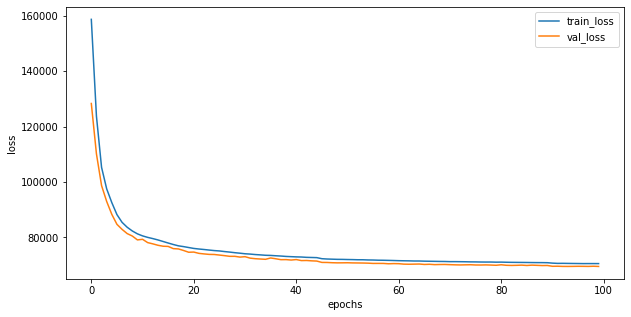

In [33]:
loss, val_loss = zip(*hist)

plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

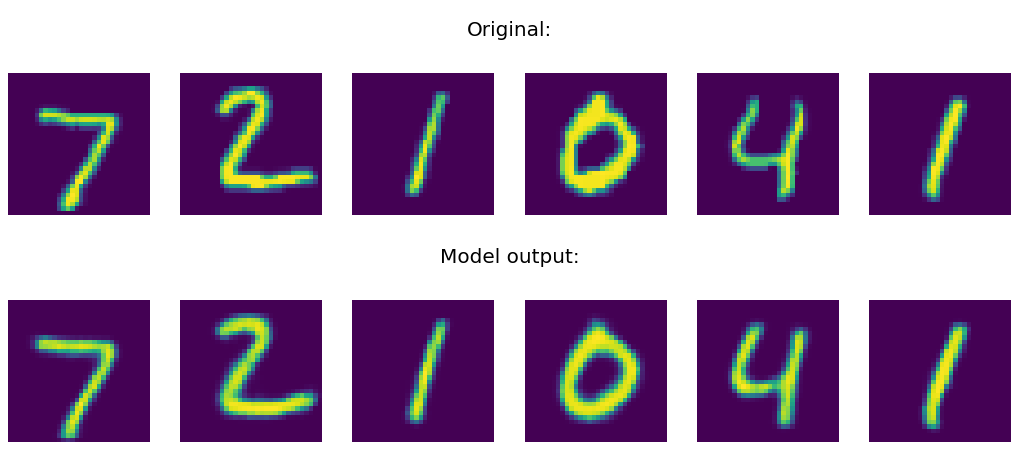

In [34]:
batch = next(iter(val_loader))
onehot_classes = torch.zeros(batch[1].size(0), 10)
for ind, elem in enumerate(onehot_classes):
    elem[batch[1][ind]] = 1
batch = batch[0]
with torch.no_grad():
    model.eval()
    outputs = model(batch.to(device), onehot_classes.to(device))

fig = plt.figure(figsize=(18, 8))
spec = fig.add_gridspec(ncols=6, nrows=4, height_ratios=[1, 3, 1, 3])

orig_ax = fig.add_subplot(spec[0, :])
orig_ax.text(0.5, 0.5, "Original:", ha="center", va="center", size=20)
orig_ax.axis("off")

for indx in range(6):
    f1_ax = fig.add_subplot(spec[1, indx])
    f1_ax.axis("off")
    f1_ax.imshow(output_to_img(batch[indx]))

    f2_ax = fig.add_subplot(spec[3, indx])
    f2_ax.axis("off")
    f2_ax.imshow(output_to_img(output[0][indx]))

sml_ax = fig.add_subplot(spec[2, :])
sml_ax.text(0.5, 0.5, "Model output:", ha="center", va="center", size=20)
sml_ax.axis("off")

plt.show()

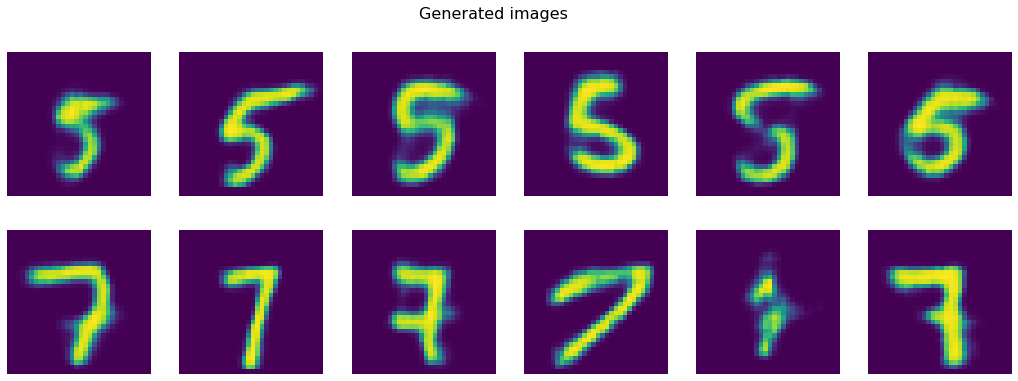

In [35]:
classes = [5] * 6 + [7] * 6
onehot_classes = torch.zeros(12, 10)
for ind, elem in enumerate(onehot_classes):
    elem[classes[ind]] = 1
with torch.no_grad():
    output_randn = model.decoder(
        torch.randn(12, latent_dim).to(device), onehot_classes.to(device)
    )
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Generated images", fontsize=16)
for indx in range(6):
    plt.subplot(2, 6, indx + 1)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx]))

    plt.subplot(2, 6, indx + 7)
    plt.axis("off")
    plt.imshow(output_to_img(output_randn[indx + 6]))

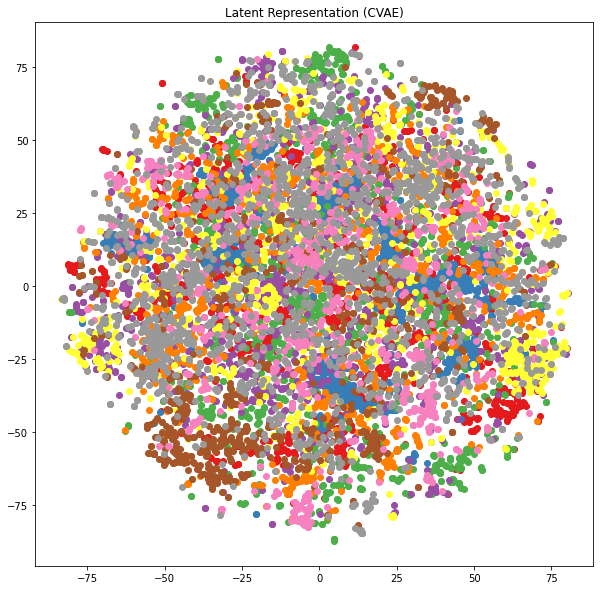

In [36]:
total_mean = []
with torch.no_grad():
    for data in val_loader:
        onehot_classes = torch.zeros(data[1].size(0), 10)
        for ind, elem in enumerate(onehot_classes):
            elem[data[1][ind]] = 1
        _, mean, _ = model.encoder(data[0].to(device), onehot_classes.to(device))
        total_mean.append(mean)

total_mean = torch.cat(total_mean, 0).cpu().numpy()
model_tsne = TSNE(n_components=2, random_state=42)
total_mean = model_tsne.fit_transform(total_mean)
classes = val_loader.dataset.targets.cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for ind in range(10):
    indxs = np.where(classes == ind)
    color = plt.cm.Set1(ind)
    plt.scatter(total_mean[indxs][:, 0], total_mean[indxs][:, 1], color=color)
plt.title("Latent Representation (CVAE)")
plt.show()

Видно, что VAE и CVAE сильно отличаются. Однако этого и следовало ожидать, в CVAE для каждого числа в латентом пространстве существует свое распределение, похожее на N(0,1), а их совокупность будет вот такой вот кучей (см. изображение снизу). В VAE же информация о метках классов не попадает в сеть, для всех чисел имеется одно распределение. Поэтому когда мы генерировали случайные картинки в VAE, получались "цифры" из кучи элементов, присутствующих во всех числах.
В CVAE декодер собирает картинку лишь из элементов какого-то определенного класса.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


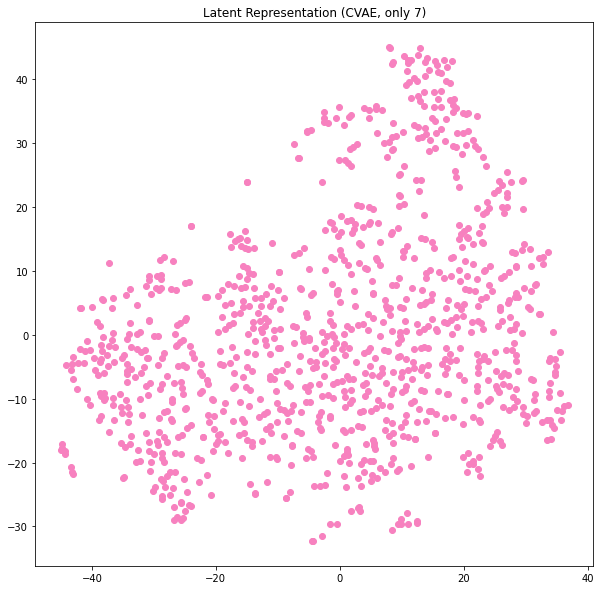

In [37]:
total_mean = []
sev_indx = val_loader.dataset.train_labels == 7
val_loader.dataset.targets = val_loader.dataset.targets[sev_indx]
val_loader.dataset.data = val_loader.dataset.data[sev_indx]
with torch.no_grad():
    for data in val_loader:
        onehot_classes = torch.zeros(data[1].size(0), 10)
        for ind, elem in enumerate(onehot_classes):
            elem[data[1][ind]] = 1
        _, mean, _ = model.encoder(data[0].to(device), onehot_classes.to(device))
        total_mean.append(mean)

total_mean = torch.cat(total_mean, 0).cpu().numpy()
model_tsne = TSNE(n_components=2, random_state=42)
total_mean = model_tsne.fit_transform(total_mean)
classes = val_loader.dataset.targets.cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for ind in range(10):
    indxs = np.where(classes == ind)
    color = plt.cm.Set1(ind)
    plt.scatter(total_mean[indxs][:, 0], total_mean[indxs][:, 1], color=color)
plt.title("Latent Representation (CVAE, only 7)")
plt.show()